Cantidad de filas de entrenamiento:  379


  0%|          | 0/75000 [00:00<?, ?it/s]

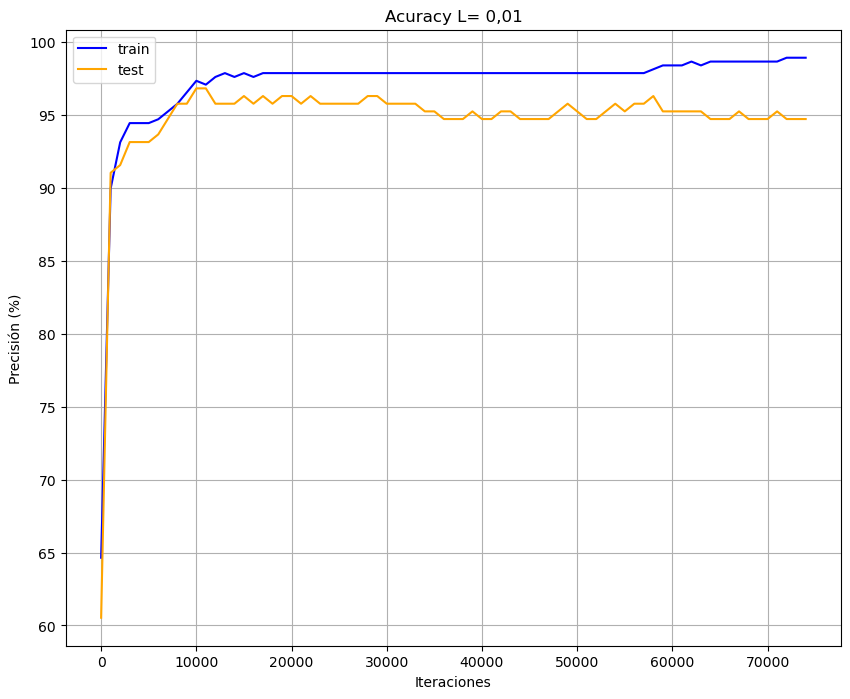

Test
95.26315789473703
Train
98.9445910290243


In [2]:
# librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

# Cargar el archivo limpio de cáncer de mama
df2 = pd.read_csv('cancer_de_mama_limpio.csv')

# Extraer variables de entrada (todas las filas, columnas de 2 a 31)
X = df2.iloc[:, 2:].values

# Extraer columna de salida (todas las filas, columna 'diagnosis')
Y = df2.iloc[:, 1].values 

# Normalizar las características con StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3)

# Número de registros de entrenamiento
n = X_train.shape[0]
print('Cantidad de filas de entrenamiento: ', n)

# Construir red neuronal con pesos y sesgos inicializados aleatoriamente
leaky_relu = lambda x: np.where(x > 0, x, x * 0.01)
logistic = lambda x: 1 / (1 + np.exp(-x))

# Semilla para reproducibilidad
np.random.seed(2)

# Inicialización de pesos
w_hidden = (np.random.rand(4, 30)*2)-1      
w_hidden2 = (np.random.rand(4, 4)*2)-1   
w_output = (np.random.rand(1, 4)*2)-1         

# Inicialización de sesgos
b_hidden = (np.random.rand(4, 1)*2)-1         
b_hidden2 = (np.random.rand(4, 1)*2)-1        
b_output = (np.random.rand(1, 1)*2)-1

# Ejecutar entradas a través de la red neuronal para obtener salidas predichas
def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden        
    A1 = leaky_relu(Z1)
    Z2 = w_hidden2 @ A1 + b_hidden2     
    A2 = leaky_relu(Z2)
    Z3 = w_output @ A2 + b_output       
    A3 = logistic(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Cálculo de precisión
def precision(X, Y):
    test_predictions = forward_prop(X.transpose())[5]
    test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), Y)
    accuracy = sum(test_comparisons.astype(int) / X.shape[0])
    return accuracy * 100

# Se realiza el descenso de gradiente y cálculo de la red entrenada

# Tasa de aprendizaje
L = 0.01 

# Derivadas de las funciones de activación
d_leaky_relu = lambda x: np.where(x > 0, x, 0.01) 
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

# Función de backward propagation
def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
    dC_dA3 = 2 * (A3 - Y)           
    dA3_dZ3 = d_logistic(Z3)
    dZ3_dW3 = A2
    dZ3_dA2 = w_output
    dC_dZ3 = dC_dA3 * dA3_dZ3

    dC_dA2 = dZ3_dA2.T @ dC_dZ3
    dA2_dZ2 = d_leaky_relu(Z2)
    dZ2_dW2 = A1
    dZ2_dA1 = w_hidden2
    dC_dZ2 = dC_dA2 * dA2_dZ2

    dC_dA1 = dZ2_dA1.T @ dC_dZ2
    dA1_dZ1 = d_leaky_relu(Z1)
    dZ1_dW1 = X
    dC_dZ1 = dC_dA1 * dA1_dZ1

    dC_dW3 = dC_dZ3 @ dZ3_dW3.T
    dC_dB3 = np.sum(dC_dZ3, axis=1, keepdims=True)

    dC_dW2 = dC_dZ2 @ dZ2_dW2.T
    dC_dB2 = np.sum(dC_dZ2, axis=1, keepdims=True)

    dC_dW1 = dC_dZ1 @ dZ1_dW1.T
    dC_dB1 = np.sum(dC_dZ1, axis=1, keepdims=True)
    
    return dC_dW1, dC_dB1, dC_dW2, dC_dB2, dC_dW3, dC_dB3

# Listas para almacenar precisión
train_accuracies = []
test_accuracies = []

# Entrenamiento de la red
for i in tqdm(range(75000)):
    idx = np.random.choice(n, 1, replace=False)
    X_sample = X_train[idx].transpose()
    Y_sample = Y_train[idx]

    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)
    dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

    # Actualizar pesos y sesgos
    w_hidden -= L * dW1
    b_hidden -= L * dB1
    w_hidden2 -= L * dW2
    b_hidden2 -= L * dB2
    w_output -= L * dW3
    b_output -= L * dB3

    # Almacenar la precisión cada 1000 iteraciones
    if i % 1000 == 0:
        train_acc = precision(X_train, Y_train)
        test_acc = precision(X_test, Y_test)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

# Graficar la evolución de la precisión
plt.figure(figsize=(10, 8))
plt.plot(range(0, 75000, 1000), train_accuracies, label='train', color='blue')
plt.plot(range(0, 75000, 1000), test_accuracies, label='test', color='orange')
plt.title('Acurracy L= 0,01')
plt.xlabel('Iteraciones')
plt.ylabel('Precisión (%)')
plt.legend()
plt.grid()
plt.show()

print('Test')
post_test_acc = precision(X_test, Y_test)
print(post_test_acc)
print('Train')
post_train_acc = precision(X_train, Y_train)
print(post_train_acc)
